In [2]:
import os

if os.name == 'nt':
    %env DOC=C:\Users\BK\Documents
else:
    %env DOC=/Users/muuzh/Documents

from AMI import automutual_info_single, automutual_info, automutual_info_k1

env: DOC=C:\Users\BK\Documents
C:\Users\BK\Documents\JIDT\infodynamics.jar


In [80]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import seaborn as sns
import pandas as pd
import time
import itertools
import scipy.stats as stats
import jpype
import datasets as datasets

In [5]:
# generate 500*500 samples of AR(2) process
a_num = 500

t1 = time.time()

lag1para = np.linspace(-2, 2, a_num)
lag2para = np.linspace(-2, 2, a_num)
series_length = 2000

param_list = np.array(list(itertools.product(lag1para, lag2para)))

ARpara = [np.r_[1, -arparams] for arparams in param_list]
AR2matrix = [ArmaProcess(ar, [1]) for ar in tqdm(ARpara)]

t2 = time.time()
print(t2-t1)
# get the range of available lag 1 and lag 2
param_condition = [process.isstationary for process in tqdm(AR2matrix)]
t3 = time.time()
print(t3-t2)
available_param = param_list[param_condition]
print(available_param.shape)

  0%|          | 0/250000 [00:00<?, ?it/s]

15.941695213317871


  0%|          | 0/250000 [00:00<?, ?it/s]

12.604175090789795
(62250, 2)


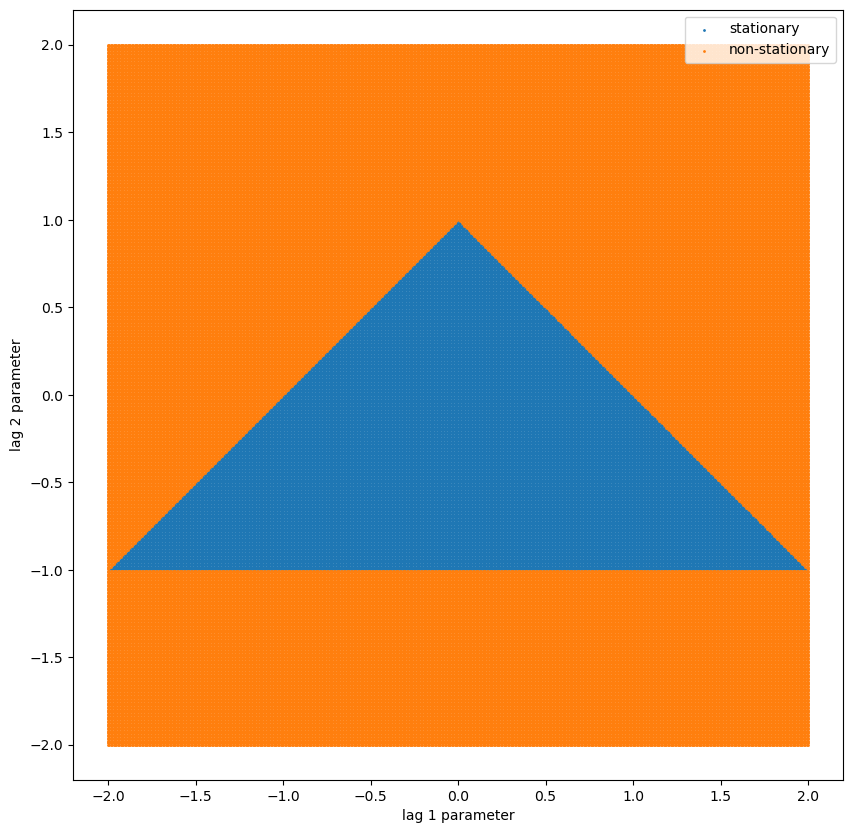

In [10]:
available_param = param_list[param_condition]
unavailable_param = param_list[~np.array(param_condition)]

plt.figure(figsize=(10,10))
plt.scatter(available_param[:,0], available_param[:,1], s=1, label='stationary')
plt.scatter(unavailable_param[:,0], unavailable_param[:,1], s=1, label='non-stationary')
plt.Axes.set_aspect(plt.gca(), 'equal')
plt.xlabel('lag 1 parameter')
plt.ylabel('lag 2 parameter')
plt.legend(loc='best')
plt.show()

In [24]:
a_num = 200

t1 = time.time()

lag1para = np.linspace(-2, 2, a_num)
lag2para = np.linspace(-1, 1, int(a_num/2))
series_length = 1000

param_list = np.array(list(itertools.product(lag1para, lag2para)))

ARpara = [np.r_[1, -arparams] for arparams in param_list]
AR2matrix_model = [ArmaProcess(ar, [1]) for ar in tqdm(ARpara)]

t2 = time.time()
print(t2-t1)
# get the range of available lag 1 and lag 2
param_condition = [process.isstationary for process in tqdm(AR2matrix)]
t3 = time.time()
print(t3-t2)
available_param = param_list[param_condition]
print(available_param.shape)

  0%|          | 0/20000 [00:00<?, ?it/s]

0.44980692863464355


  0%|          | 0/20000 [00:00<?, ?it/s]

1.0348308086395264
(9720, 2)


In [28]:
stationary_ARpara = [np.r_[1, -arparams] for arparams in available_param]
stationary_AR2matrix = np.array([ArmaProcess(ar, [1]).generate_sample(series_length) for ar in tqdm(stationary_ARpara)])
stationary_AR2matrix.shape
# stationary_AR2matrix = AR2matrix[param_condition,:]
# stationary_AR2matrix.shape

  0%|          | 0/9720 [00:00<?, ?it/s]

(9720, 1000)

  0%|          | 0/9720 [00:00<?, ?it/s]

<Figure size 500x1000 with 0 Axes>

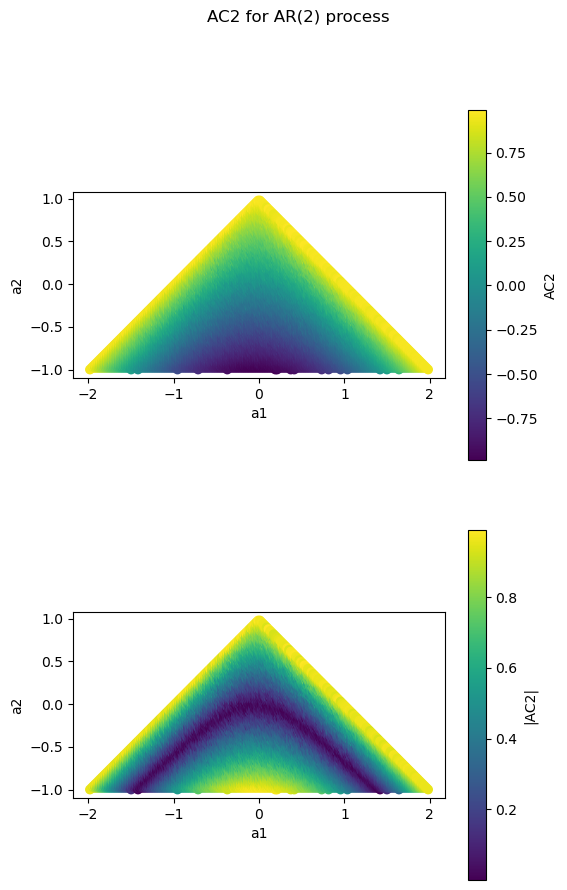

In [137]:
AC2 = [acf(series, nlags=2,fft=True)[2] for series in tqdm(stationary_AR2matrix)]

# AC2

plt.figure(figsize=(5,10))
fig, [ax1,ax2] = plt.subplots(2, 1,figsize=(6,10))

ax1.scatter(available_param[:,0], available_param[:,1], c=AC2)
ax1.set_xlabel('a1')
ax1.set_ylabel('a2')
ax1.set_aspect('equal')

cbar = fig.colorbar(ax=ax1, mappable=ax1.collections[0])
cbar.set_label('AC2')

ax2.scatter(available_param[:,0], available_param[:,1], c=np.abs(AC2))
ax2.set_xlabel('a1')
ax2.set_ylabel('a2')
ax2.set_aspect('equal')

cbar = fig.colorbar(ax=ax2, mappable=ax2.collections[0])
cbar.set_label('|AC2|')

fig.suptitle('AC2 for AR(2) process')
plt.show()

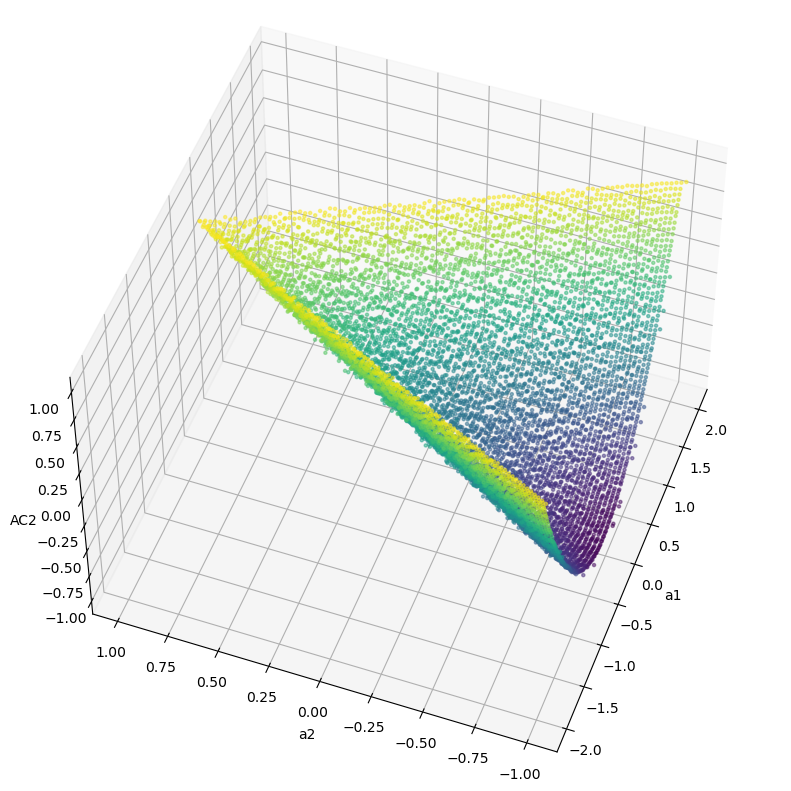

In [147]:
# have a 3d look of the AC2
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
# mpl.style.use('default')
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(available_param[:,0], available_param[:,1], AC2, c=AC2, alpha=0.5, s = 5)
ax.set_xlabel('a1')
ax.set_ylabel('a2')
ax.set_zlabel('AC2')
# ax.view_init(elev=50, azim=-160)
ax.view_init(elev=50, azim=-160)
plt.show()

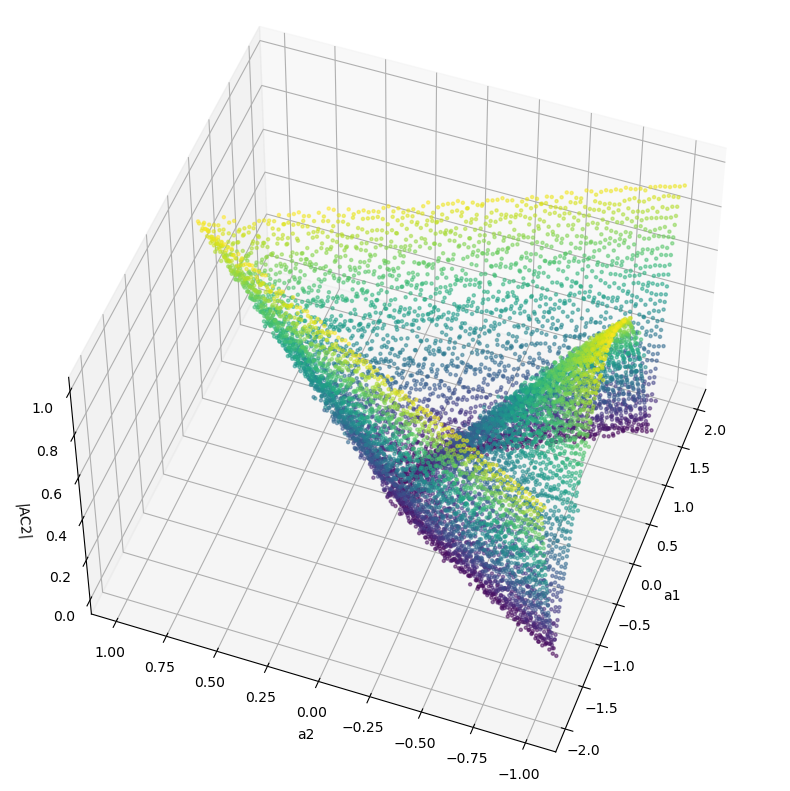

In [148]:
# have a 3d look of the AC2
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
# mpl.style.use('default')
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(available_param[:,0], available_param[:,1], np.abs(AC2), c=np.abs(AC2), alpha=0.5, s = 5)
ax.set_xlabel('a1')
ax.set_ylabel('a2')
ax.set_zlabel('|AC2|')
# ax.view_init(elev=50, azim=-160)
ax.view_init(elev=50, azim=-160)
plt.show()

In [30]:
AMI2 = automutual_info(stationary_AR2matrix, 2, 3)


Processing:   0%|          | 0/9720 [00:00<?, ?it/s]

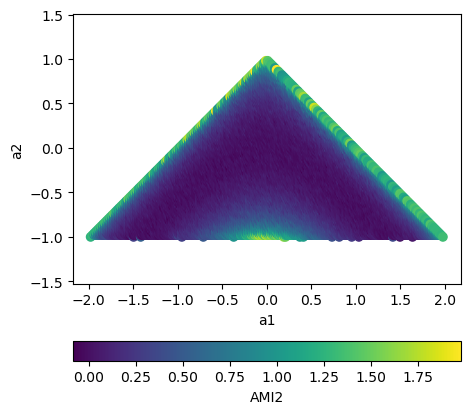

In [130]:

plt.figure(figsize=(5,5))


plt.scatter(available_param[:,0], available_param[:,1], c=AMI2)
plt.xlabel('a1')
plt.ylabel('a2')
plt.axis('equal')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('AMI2')

fig.suptitle('AC2 for AR(2) process')
plt.show()

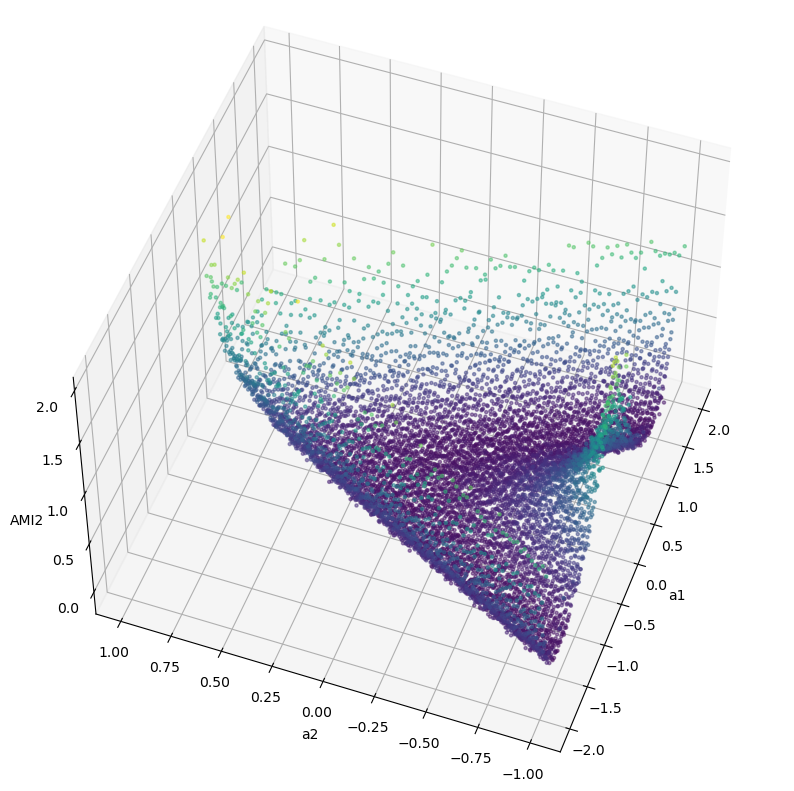

In [136]:
# have a 3d look of the AMI2
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib as mpl
# mpl.style.use('default')
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(available_param[:,0], available_param[:,1], AMI2, c=AMI2, alpha=0.5, s = 5)
ax.set_xlabel('a1')
ax.set_ylabel('a2')
ax.set_zlabel('AMI2')
ax.view_init(elev=50, azim=-160)
plt.show()


In [103]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [161]:
def poincare_plot(data, stride=1):
    """
    Create a Poincare plot from a time series.

    Parameters
    ----------
    data : array_like
        The time series data.
    stride : int, optional
        The stride between consecutive points in the time series. Default is 1.

    Returns
    -------
    tuple
        A tuple containing the x and y coordinates of the Poincare plot.
    """
    x = data[:-stride]
    y = data[stride:]
    return x, y

AR2

  0%|          | 0/500 [00:00<?, ?it/s]

Pairs of parameters (r, s) for which the time series does not explode:
(0.0, 0.9779559118236472)
(0.0, 0.9859719438877754)
(0.0, 0.9939879759519037)
(0.0, 1.002004008016032)
(0.008016032064128256, 0.9859719438877754)
(0.008016032064128256, 0.9939879759519037)
(0.008016032064128256, 1.002004008016032)
(0.008016032064128256, 1.0100200400801602)
(0.01603206412825651, 0.9779559118236472)
(0.01603206412825651, 0.9859719438877754)
(0.01603206412825651, 0.9939879759519037)
(0.01603206412825651, 1.002004008016032)
(0.01603206412825651, 1.0100200400801602)
(0.01603206412825651, 1.0180360721442885)
(0.024048096192384766, 0.969939879759519)
(0.024048096192384766, 0.9779559118236472)
(0.024048096192384766, 1.002004008016032)
(0.024048096192384766, 1.0100200400801602)
(0.024048096192384766, 1.0180360721442885)
(0.024048096192384766, 1.0260521042084167)
(0.03206412825651302, 0.969939879759519)
(0.03206412825651302, 1.0100200400801602)
(0.03206412825651302, 1.0180360721442885)
(0.03206412825651302, 1

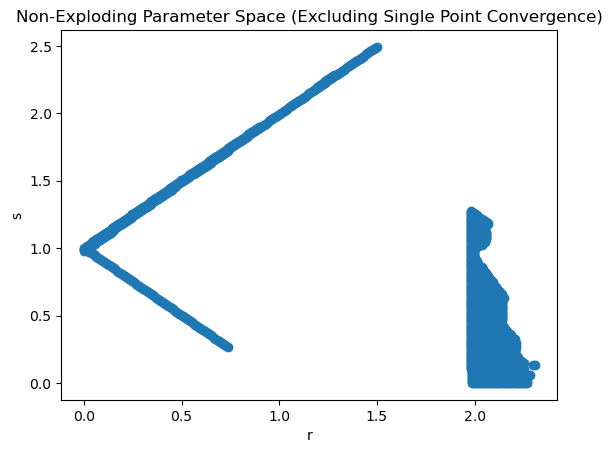

In [172]:
def step2_logistic_map(x0, x1, r, s, n, threshold=100):
    x = np.zeros(n+1)
    x[0] = x0
    x[1] = x1

    for i in range(1, n):
        x[i+1] = r * x[i] * (1 - x[i-1]) + s * x[i-1] * (1 - x[i])
        
        # Check for explosion
        if abs(x[i+1]) > threshold:
            return None

    return x

def is_converged_to_single_point(time_series, tolerance=1e-6):
    last_values = time_series[-5:]
    if np.all(np.abs(np.diff(last_values)) < tolerance):
        return True
    return False
# Parameters
x0 = 0.5
x1 = 0.5
n = 1000
threshold = 1

# the range of interaction parameters
r_values = np.linspace(0, 4, 500)
s_values = np.linspace(0, 4, 500)

# Store the pairs of parameters for which the time series does not explode
non_exploding_params = []

for r in tqdm(r_values):
    for s in s_values:
        time_series = step2_logistic_map(x0, x1, r, s, n, threshold)

        if time_series is not None and not is_converged_to_single_point(time_series):
            non_exploding_params.append((r, s))
            # print(time_series)


print("Pairs of parameters (r, s) for which the time series does not explode:")
for params in non_exploding_params:
    print(params)

r_non_exploding, s_non_exploding = zip(*non_exploding_params)
plt.scatter(r_non_exploding, s_non_exploding)
plt.xlabel("r")
plt.ylabel("s")
plt.title("Non-Exploding Parameter Space (Excluding Single Point Convergence)")
plt.show()

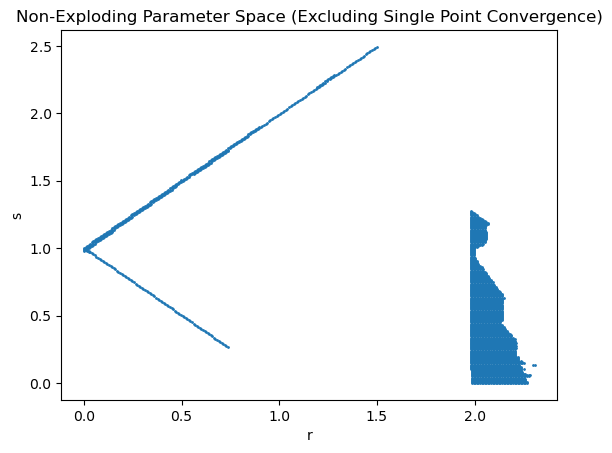

In [173]:
r_non_exploding, s_non_exploding = zip(*non_exploding_params)
plt.scatter(r_non_exploding, s_non_exploding, s=1)
plt.xlabel("r")
plt.ylabel("s")
plt.title("Non-Exploding Parameter Space (Excluding Single Point Convergence)")
plt.show()

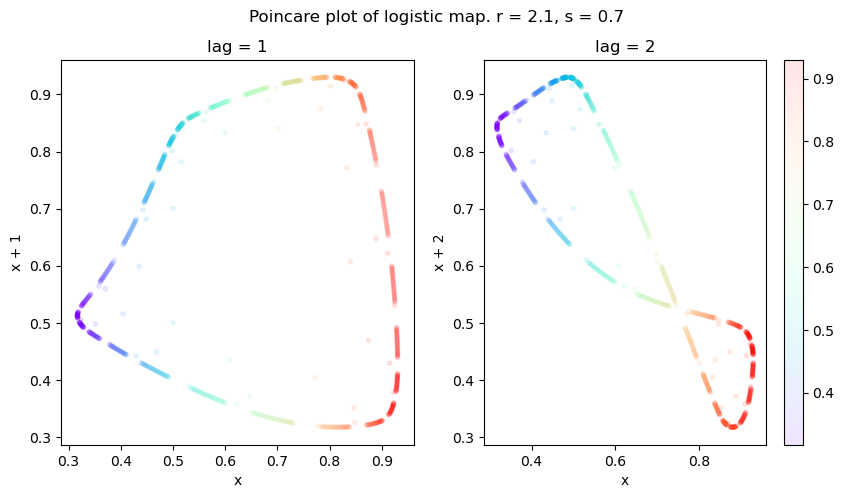

C:\Users\BK\AppData\Local\Temp\ipykernel_12668\3379528739.py:46: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(aaa)


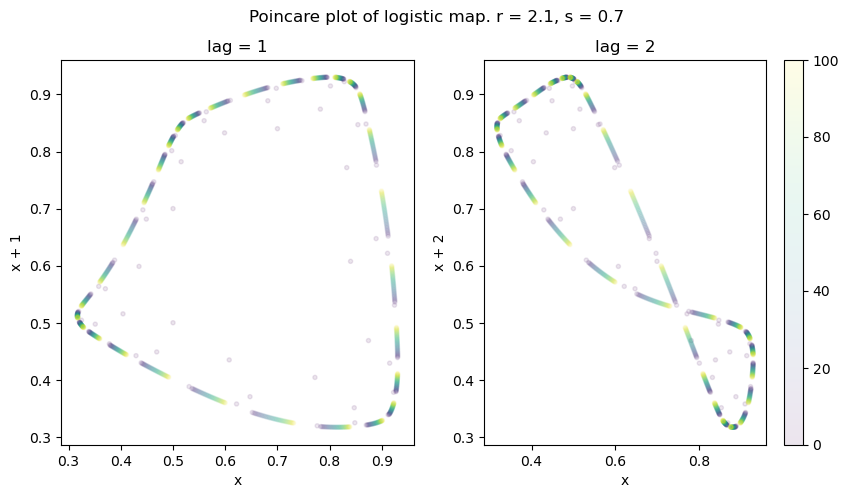

In [229]:
r = 2.1
s = 0.7
x = step2_logistic_map(x0, x1, r, s, n, threshold)
# plt.figure()
# lag = 1
# plt.scatter(x[:-lag], x[lag:], marker='.',alpha=0.1)
# plt.xlabel("x")
# plt.ylabel("x + 1")
# plt.title("Poincare plot of logistic map. r = {}, s = {}, lag = {}".format(r, s, lag))
# plt.show()
# lag = 2
# plt.scatter(x[:-lag], x[lag:], marker='.',alpha=0.1)
# plt.xlabel("x")
# plt.ylabel("x + 2")
# plt.title("Poincare plot of logistic map. r = {}, s = {}, lag = {}".format(r, s, lag))
# plt.show()

# do the same job but plot them in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
lag = 1
pcm = ax1.scatter(x[:-lag], x[lag:], marker='.',alpha=0.1, c=x[:-1], cmap="rainbow")
ax1.set_xlabel("x")
ax1.set_ylabel("x + 1")
ax1.set_title("lag = {}".format(lag))
lag = 2
pcm =  ax2.scatter(x[:-lag], x[lag:], marker='.',alpha=0.1, c=x[:-2], cmap="rainbow")
ax2.set_xlabel("x")
ax2.set_ylabel("x + 2")
ax2.set_title("lag = {}".format(lag))
plt.suptitle("Poincare plot of logistic map. r = {}, s = {}".format(r, s))
fig.colorbar(pcm)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
lag = 1
pcm = ax1.scatter(x[:-lag], x[lag:], marker='.',alpha=0.1, c=np.linspace(0, 100, len(x[:-1])))
ax1.set_xlabel("x")
ax1.set_ylabel("x + 1")
ax1.set_title("lag = {}".format(lag))
lag = 2
pcm = ax2.scatter(x[:-lag], x[lag:], marker='.',alpha=0.1, c=np.linspace(0, 100, len(x[:-2])))
ax2.set_xlabel("x")
ax2.set_ylabel("x + 2")
ax2.set_title("lag = {}".format(lag))
plt.suptitle("Poincare plot of logistic map. r = {}, s = {}".format(r, s))
fig.colorbar(aaa)
plt.show()




In [247]:
# generate time series for all non_exploding_params, use vstack and tqdm
logistic_matrix = np.array([])
for r, s in tqdm(non_exploding_params):
    logistic_matrix = np.vstack((logistic_matrix, step2_logistic_map(x0, x1, r, s, n, threshold))) if logistic_matrix.size else step2_logistic_map(x0, x1, r, s, n, threshold)


  0%|          | 0/3459 [00:00<?, ?it/s]

In [250]:
logisticAC2 = [acf(series, nlags=2,fft=True)[2] for series in tqdm(logistic_matrix)]


  0%|          | 0/3459 [00:00<?, ?it/s]

<Figure size 500x1000 with 0 Axes>

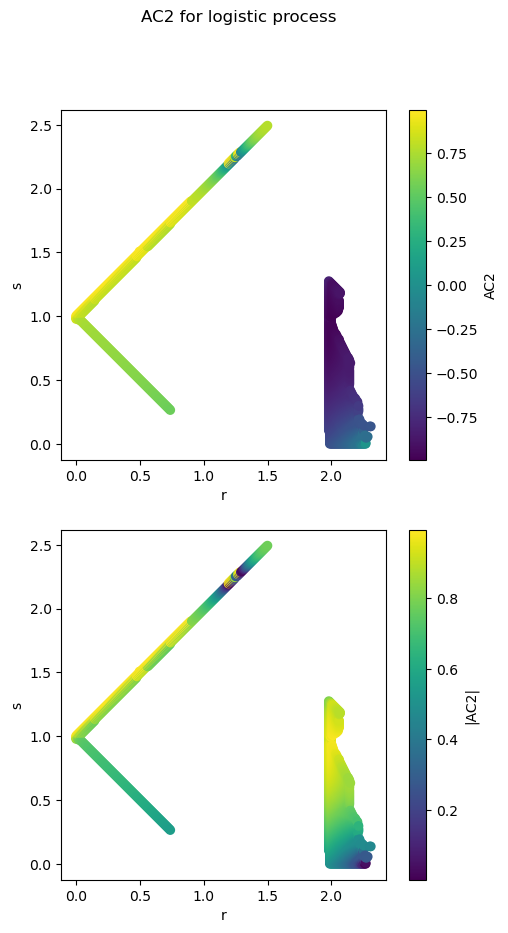

In [251]:
plt.figure(figsize=(5,10))
fig, [ax1,ax2] = plt.subplots(2, 1,figsize=(6,10))

ax1.scatter(r_non_exploding, s_non_exploding, c=logisticAC2)
ax1.set_xlabel('r')
ax1.set_ylabel('s')
ax1.set_aspect('equal')

cbar = fig.colorbar(ax=ax1, mappable=ax1.collections[0])
cbar.set_label('AC2')

ax2.scatter(r_non_exploding, s_non_exploding, c=np.abs(logisticAC2))
ax2.set_xlabel('r')
ax2.set_ylabel('s')
ax2.set_aspect('equal')

cbar = fig.colorbar(ax=ax2, mappable=ax2.collections[0])
cbar.set_label('|AC2|')

fig.suptitle('AC2 for logistic process')
plt.show()

  0%|          | 0/3459 [00:00<?, ?it/s]

IndexError: list index out of range

<Figure size 500x1000 with 0 Axes>

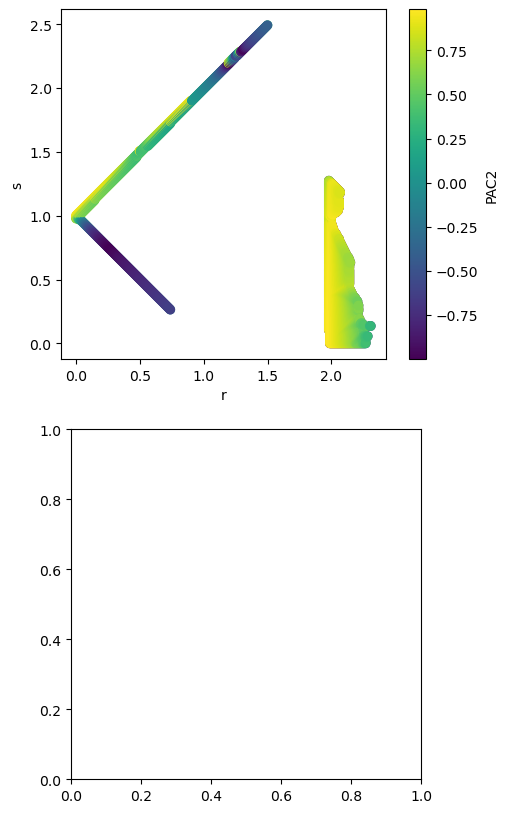

In [254]:
logisticPAC2 = [pacf(series, nlags=2)[2] for series in tqdm(logistic_matrix)]

plt.figure(figsize=(5,10))
fig, [ax1,ax2] = plt.subplots(2, 1,figsize=(6,10))

ax1.scatter(r_non_exploding, s_non_exploding, c=logisticPAC2)
ax1.set_xlabel('r')
ax1.set_ylabel('s')
ax1.set_aspect('equal')

cbar = fig.colorbar(ax=ax1, mappable=ax1.collections[0])
cbar.set_label('PAC2')

ax1.scatter(r_non_exploding, s_non_exploding, c=np.abs(logisticPAC2))
ax1.set_xlabel('r')
ax1.set_ylabel('s')
ax2.set_aspect('equal')

cbar = fig.colorbar(ax=ax2, mappable=ax2.collections[0])
cbar.set_label('|PAC2|')

fig.suptitle('PAC2 for logistic process')
plt.show()

In [256]:
logisticAMI2 = automutual_info(logistic_matrix, 2, 3)

Processing:   0%|          | 0/3459 [00:00<?, ?it/s]

KeyboardInterrupt: 